# Image Classification using AWS SageMaker

## by 'Femi Bolarinwa

In this notebook i performed ETL on dog breed datasets, trained classification model using deep learning and deployed the model on AWS

In [1]:
# Installing needed packages

!pip install smdebug
!pip install -U sagemaker

In [2]:
# Importing needed packages

import sagemaker
import boto3
import os
import csv

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
# General AWS macros
session = sagemaker.Session()
bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))
region = session.boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Default Bucket: sagemaker-us-east-1-853962786057
AWS Region: us-east-1
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
RoleArn: arn:aws:iam::853962786057:role/service-role/AmazonSageMaker-ExecutionRole-20231204T140615


## Dataset

The dataset contains images from 133 dog breeds. Its split into training, testing and validation datasets. The next few cells download the dataset into s3 bucket, preprocess and plot sample of the dataset. Torch dataset loader is used to ease the process of training the neural network

In [17]:
#Fetching data

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-12-05 20:35:29--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.144, 52.219.112.96, 52.219.193.104, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

dogImages.zip.1      75%[==============>     ] 813.12M  48.3MB/s    eta 6s     ^C
Archive:  dogImages.zip
replace dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
# Custom function to create metadata csv files with keys: path, classification to mimic MNIST dataset description. 
#Makes it easier to create proper dataloader for these data


def create_metadata(database_path):
    with open(os.path.join(database_path, 'meta.csv'), 'w', encoding='UTF8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Filename'])
        for root, dirs, files in os.walk(database_path):
            files.sort()
            for file in files:
                if file.lower().endswith('.jpg'):
                    classification_id = int(root.split("/")[2].split(".")[0])-1
                    rel_path = os.path.join(root, file)
                    row = [classification_id, rel_path]
                    writer.writerow(row)
    print('Creating metadata completed for file', os.path.join(database_path, 'meta.csv'))
                    
create_metadata('dogImages/test')
create_metadata('dogImages/train')
create_metadata('dogImages/valid')

Creating metadata completed for file dogImages/test/meta.csv
Creating metadata completed for file dogImages/train/meta.csv
Creating metadata completed for file dogImages/valid/meta.csv


In [5]:
# Creating labels map
database_path = 'dogImages'

def create_labels_map(database_path):
    output_filename = os.path.join(database_path, 'labels.csv')
    with open(output_filename, 'w', encoding='UTF8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Breed name'])
        for root, dirs, files in os.walk(os.path.join(database_path, 'test')):
            dirs.sort()
            for directories in dirs:
                splitted_dir_name = directories.split(".")
                if (len(splitted_dir_name) == 2 and len(splitted_dir_name[0])>0):
                    splitted_dir_name[0] = int(splitted_dir_name[0]) - 1
                    writer.writerow(splitted_dir_name)
            break
    print('Creating labels map completed. Output', output_filename)
    
create_labels_map(database_path)

Creating labels map completed. Output dogImages/labels.csv


In [6]:
#statistics on dataset
import pandas as pd
labels_map = pd.read_csv('dogImages/labels.csv')
test_meta = pd.read_csv('dogImages/test/meta.csv')
valid_meta = pd.read_csv('dogImages/valid/meta.csv')
train_meta = pd.read_csv('dogImages/train/meta.csv')

print('%d total dog categories.' % len(labels_map))
print('%s total dog images.\n' % str(len(test_meta)+len(valid_meta)+len(train_meta)))
print('%d training dog images.' % len(train_meta))
print('%d validation dog images.' % len(valid_meta))
print('%d test dog images.'% len(test_meta))

133 total dog categories.
8351 total dog images.

6680 training dog images.
835 validation dog images.
836 test dog images.


label Finnish_spitz id 66
label Australian_terrier id 12
label Ibizan_hound id 82
label Great_dane id 77
label Otterhound id 113
label Beagle id 15
label Dalmatian id 56
label American_foxhound id 6
label Dachshund id 55


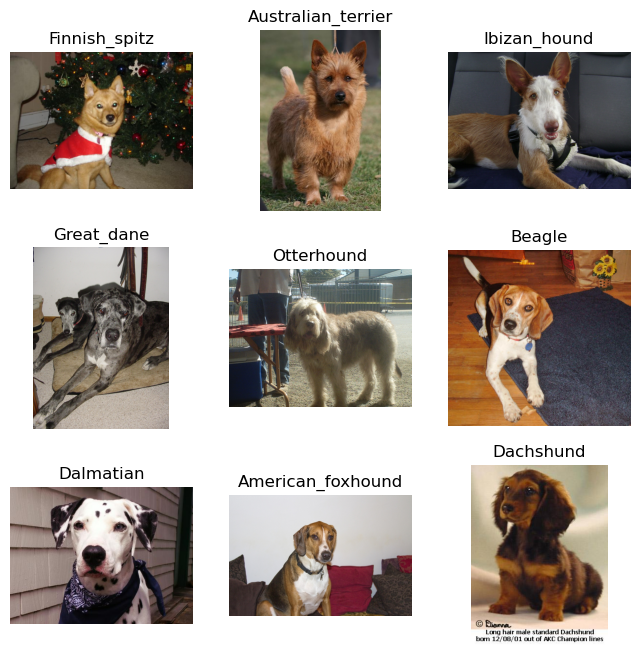

In [7]:
# Plotting some of the images
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
labels_map = pd.read_csv('dogImages/labels.csv')
test_meta = pd.read_csv('dogImages/test/meta.csv')

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = random.randint(0, len(test_meta))
    img_path = test_meta.iloc[sample_idx, 1]
    label_id = test_meta.iloc[sample_idx, 0]
    label = labels_map.iloc[int(label_id), 1]
    print("label", label, "id", label_id)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(img_path).squeeze(), cmap="gray")
plt.show()
figure.savefig('sample_dataset_images.png')

In [8]:
# Creating test image loader for HPO
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class DogBreedDataset(Dataset):
    def __init__(self, annotations_file, base_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.base_dir = base_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_dir, self.img_labels.iloc[idx, 1])
        image = read_image(img_path)
        label = int(self.img_labels.iloc[idx, 0])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


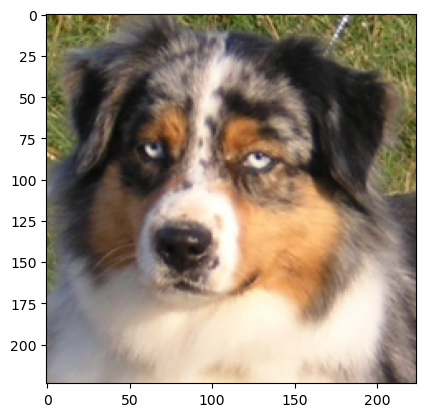

Label: 11


In [9]:
# Displaying sample image and label.
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
# Some magic values which are equally the same across multiple examples for different datasets.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image_transform = transforms.Compose([
    transforms.Resize([256, ]),
    transforms.CenterCrop(224),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=mean, std=std)])
training_data = DogBreedDataset(annotations_file = 'dogImages/train/meta.csv', base_dir = '.', transform = image_transform)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().numpy().transpose(1,2,0)
label = train_labels[0]
plt.imshow(img*std+mean)
plt.show()
print(f"Label: {label}")

In [ ]:
# Uploading data to S3 bucket for training
import os

os.environ["DATABASE_PATH"] = "s3://"+ bucket+ "/dogImages/"
!aws s3 cp dogImages ${DATABASE_PATH} --recursive

upload: dogImages/labels.csv to s3://sagemaker-us-east-1-853962786057/dogImages/labels.csv
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg to s3://sagemaker-us-east-1-853962786057/dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-us-east-1-853962786057/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00149.jpg to s3://sagemaker-us-east-1-853962786057/dogImages/test/002.Afghan_hound/Afghan_hound_00149.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://sagemaker-us-east-1-853962786057/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://sagemaker-us-east-1-853962786057/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00141.jpg to s3://sagemaker-us-east-1-85396278605

## Hyperparameter Tuning
This section finetunes a pretrained Resnet model with hyperparameter tuning. Two hyperparameters were selected for tuning:

learning rate - to find when the model learns fast enough without overfitting

batch-size - to find an optimal batch size to optimize training time

See the hpo.py script for more details.

In [10]:
#Declaring your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": sagemaker.tuner.ContinuousParameter(0.001, 0.1),
    "batch-size": sagemaker.tuner.CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [11]:
#Creating estimator
from sagemaker.pytorch import PyTorch
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

# Creating tuner
tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [ ]:
# Fitting HP Tuner
os.environ["SM_CHANNEL_TRAINING"] = "s3://"+ bucket+ "/dogImages/"
os.environ['SM_MODEL_DIR']="s3://"+ bucket+ "/model/" # where model will be stored
tuner.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=True)# include data channels

In [13]:
# Getting the best estimators and the best hyperparameters
best_estimator = tuner.best_estimator()

#Getting the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-12-05 20:52:27 Starting - Found matching resource for reuse
2023-12-05 20:52:27 Downloading - Downloading input data
2023-12-05 20:52:27 Training - Training image download completed. Training in progress.
2023-12-05 20:52:27 Uploading - Uploading generated training model
2023-12-05 20:52:27 Completed - Resource reused by training job: pytorch-training-231205-2038-005-1ed474e3


{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"256"',
 'lr': '0.0015249791503711243',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-12-05-20-38-07-462"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-853962786057/pytorch-training-2023-12-05-20-38-07-462/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
I'll be using the best hyperparameters to create and finetune a new model

**Note:** I'll use the `train_model.py` script to perform model profiling and debugging.

### Model Training

In [14]:
hyperparameter_values = {
    "lr": 0.0015249791503711243,
    "batch-size": 256,
}

In [15]:
# Setting up debugging, profiling rules and hooks

from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


# profiling rules
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [16]:
# Creating and fitting an estimator

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version='py36',
    hyperparameters=hyperparameter_values,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)


os.environ["SM_CHANNEL_TRAINING"] = "s3://"+ bucket+ "/dogImages/"
os.environ['SM_MODEL_DIR']="s3://"+ bucket+ "/model_train/" # where model will be stored
estimator.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=False)
job_name = estimator._current_job_name
print('Job name:', job_name)
debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print('Debug artifacts path', debug_artifacts_path)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-12-05-21-06-28-495


Using provided s3_resource
Job name: pytorch-training-2023-12-05-21-06-28-495
Debug artifacts path s3://sagemaker-us-east-1-853962786057/pytorch-training-2023-12-05-21-06-28-495/debug-output


### Extracting debug info

In [43]:
# Plotting a debugging output.

import boto3
session = boto3.session.Session()
region = session.region_name

if not job_name:
    job_name = "pytorch-training-2023-12-05-21-06-28-495" # put a job name here to load it
estimator = sagemaker.estimator.Estimator.attach(job_name)

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml

2023-12-05 21:22:52 Starting - Preparing the instances for training
2023-12-05 21:22:52 Downloading - Downloading input data
2023-12-05 21:22:52 Training - Training image download completed. Training in progress.
2023-12-05 21:22:52 Uploading - Uploading generated training model
2023-12-05 21:22:52 Completed - Training job completed
Training jobname: pytorch-training-2023-12-05-21-06-28-495
Region: us-east-1


In [ ]:
!pip install bokeh

In [44]:
# Displaying the profiler output
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-853962786057/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-853962786057/pytorch-training-2023-12-05-21-06-28-495/profiler-output


Profiler data from system is available


In [ ]:
# Plotting a CPU utilization plot.
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

### Displaying the latest training job’s rule summary in real time

In [46]:

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [47]:
import time
from IPython import display

%matplotlib inline

while description["SecondaryStatus"] not in {"Stopped", "Completed", "Failed"}:
    description = client.describe_training_job(TrainingJobName=job_name)
    primary_status = description["TrainingJobStatus"]
    secondary_status = description["SecondaryStatus"]
    print("====================================================================")
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    print("====================================================================")
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
        print("====================================================================")
    print("Current time: ", time.asctime())
    display.clear_output(wait=True)
    time.sleep(10) # in seconds

No issues found by debugger during training. I suppose i could have had an issue with the computing resources if i didnt choose sufficiently large instance type

In [77]:
# Check Training Performance
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

if not debug_artifacts_path:
    debug_artifacts_path = "s3://sagemaker-us-east-1-071394031625/pytorch-training-2023-12-05-21-06-28-495/debug-output/"


In [78]:
trial = create_trial(debug_artifacts_path)

[2023-12-05 22:40:48.667 default:1881 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-853962786057/pytorch-training-2023-12-05-21-06-28-495/debug-output


In [79]:
trial.tensor_names()

[2023-12-05 22:40:52.370 default:1881 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-12-05 22:40:53.392 default:1881 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [80]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

6

In [81]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

6

In [82]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)
    
    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    fig.savefig('training_debug_values.png')

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


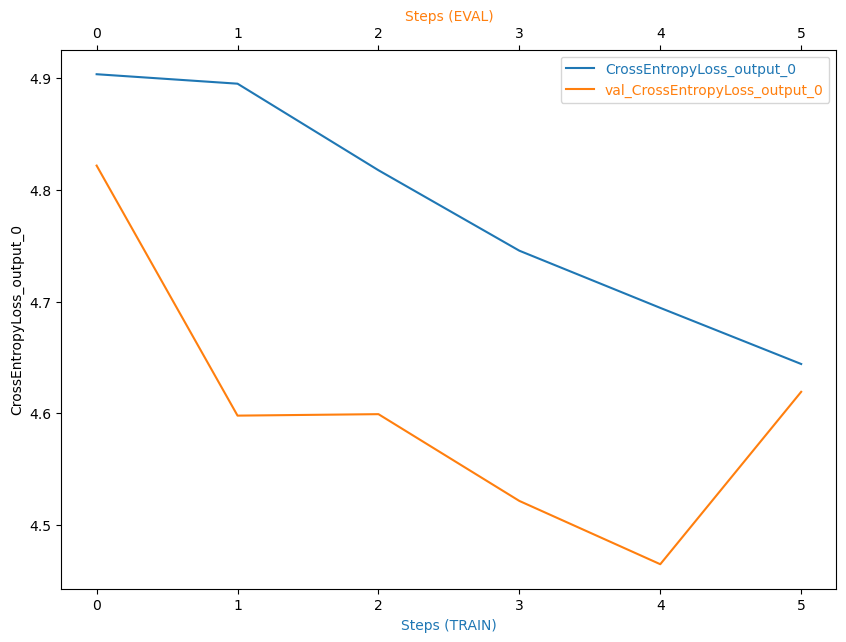

In [83]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

### Displaying profiler report

In [84]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-853962786057/pytorch-training-2023-12-05-21-06-28-495/rule-output


In [85]:
! aws s3 ls {rule_output_path} --recursive

2023-12-05 21:18:31     364075 pytorch-training-2023-12-05-21-06-28-495/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-12-05 21:18:31     211132 pytorch-training-2023-12-05-21-06-28-495/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-12-05 21:18:26        192 pytorch-training-2023-12-05-21-06-28-495/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-12-05 21:18:26        200 pytorch-training-2023-12-05-21-06-28-495/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-12-05 21:18:26       1618 pytorch-training-2023-12-05-21-06-28-495/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-12-05 21:18:26        127 pytorch-training-2023-12-05-21-06-28-495/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-12-05 21:18:26        199 pytorch-training-2023-12-05-21-06-28-495/rule-output/ProfilerReport/profiler-output/profiler-re

In [86]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-853962786057/pytorch-training-2023-12-05-21-06-28-495/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-853962786057/pytorch-training-2023-12-05-21-06-28-495/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-853962786057/pytorch-training-2023-12-05-21-06-28-495/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-853962786057/pytorch-training-2023-12-05-21-06-28-495/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-853962786057/pytorch-training-2

In [87]:
import os, IPython
# get the autogenerated folder name of profiler report
profiler_report_name = [rule["RuleConfigurationName"] for rule in estimator.latest_training_job.rule_job_summary()
                        if "Profiler" in rule["RuleConfigurationName"]
                       ][0]

print(profiler_report_name)
IPython.display.HTML(filename=profiler_report_name+"/profiler-output/profiler-report.html")

ProfilerReport


## Model Deploying

In [56]:
# create ImagePredictor - without it the Image function won't be able to decode bytes
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [57]:
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-853962786057/pytorch-training-2023-12-05-21-06-28-495/output/model.tar.gz


In [58]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [88]:
# This command creates an endpoint
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-853962786057/pytorch-training-2023-12-05-21-06-28-495/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-853962786057/pytorch-inference-2023-12-05-21-32-56-179/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-12-05-23-36-24-216
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-12-05-23-36-24-997
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-12-05-23-36-24-997


-----!

In [61]:
test_image = "Anatolian_shepherd_dog_00690.jpg"
with open(test_image, "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)

type(img_bytes)

bytearray

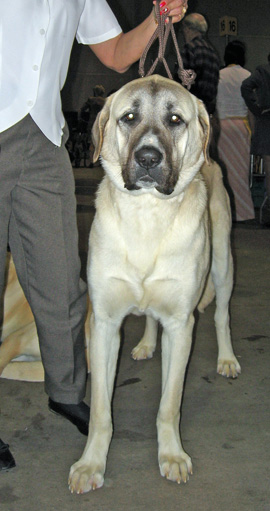

In [62]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [63]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [64]:
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(133), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Raw prediction result:
[[0.4502583146095276, -0.1586996465921402, 0.0351739339530468, 0.5143435001373291, 0.15903769433498383, -0.25109586119651794, 0.05624934658408165, 0.9280489087104797, -0.3828769028186798, 0.3375493288040161, 0.7131880521774292, -0.8021631240844727, 0.2150968462228775, -0.31675198674201965, -0.04905164614319801, -0.24430960416793823, -0.12241260707378387, -0.8129993081092834, 0.47792690992355347, -0.05278812348842621, 0.2943311631679535, -0.3179756999015808, -0.15036433935165405, 0.1922924816608429, -0.8496206402778625, -1.0441601276397705, -0.1757219284772873, -0.09750255197286606, -0.04761987552046776, -0.3297038674354553, -0.425140917301178, 0.26051366329193115, -0.2451096475124359, 0.7919526100158691, 0.292618066072464, 0.23222097754478455, 0.1370490938425064, -0.4983055591583252, -0.18915805220603943, 0.16741062700748444, 0.4923677444458008, 0.6934036016464233, 0.2656930088996887, 0.7027165293693542, -0.33802661299705505, -0.918429970741272, 0.366063475608825

Test image is an 'american staffordshire terrier', classification id of 7. Model prediction is correct

In [89]:
# shutdown/delete endpoint after work is done to save cost
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-12-05-23-36-24-997
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-12-05-23-36-24-997
